# Sesión 14: Generative Adversarial Networks

---

Martes 7 de Noviembre de 2023

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display
from tensorflow.keras import layers

### Preparación de datos

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
# Cambiar el tamaño (60000, 28, 28, 1)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') 

# Normalizar las imagenes a [-1, 1]
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Red - Generador

In [4]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # 12544
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256))) # 7, 7, 256
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) # 7, 7, 128
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # 14, 14, 64
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # 28, 28, 1
  assert model.output_shape == (None, 28, 28, 1)

  return model

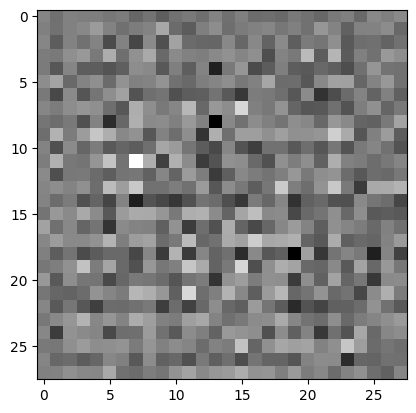

In [5]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
genereted_image = generator(noise, training=False)

plt.imshow(genereted_image[0, :, :, 0], cmap='gray')

### Red - Discriminador

In [6]:
def make_discriminador_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])) # 14, 14, 64
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) # 7, 7, 128
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten()) # 6272
  model.add(layers.Dense(1)) # 1

  return model

In [7]:
discriminador = make_discriminador_model()
decision = discriminador(genereted_image)
print (decision)

tf.Tensor([[-0.00083816]], shape=(1, 1), dtype=float32)


### Funciones de perdida y optimizadores


In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
# Función de pérdida para el discriminador
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  return total_loss

In [10]:
# Función de pérdida para el generador
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
# Optimizadores para cada red
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Checkpoints

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminador)

### Entrenamiento 

In [13]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16 # Usaremos esta matriz (16, 16) para visualizar las imágenes generadas del generador

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  # GradientTape para el generador y el discriminador
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    # Salida del discriminador
    real_output = discriminador(images, training=True)
    fake_output = discriminador(generated_images, training=True)

    # Funciones de pérdida
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Gradientes
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  # Optimizadores
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminador.trainable_variables))